In [1]:
import cv2
import igraph as ig
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame 
import pandas as pd
from sklearn import datasets 
from sklearn.mixture import GaussianMixture
import scipy.sparse as sp

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), max(self.ix , x), max(self.iy , y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), max(self.ix , x), max(self.iy , y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 
        #self.FLAGS['rect_over']=True
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def run(filename: str):
    COLORS = {'BLACK' : [0,0,0],'RED'   : [0, 0, 255],'GREEN' : [0, 255, 0],'BLUE'  : [255, 0, 0],'WHITE' : [255,255,255]}

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {'RECT' : (0, 0, 1, 1),'DRAW_STROKE': False,'DRAW_RECT' : False,'rect_over' : False,'rect_or_mask' : -1,'value' : DRAW_FG}

    img = cv2.imread(filename)
    #mg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    img2 = img.copy()                               
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = img.copy()        # output image to be shown
    img1=img.copy()
    # Input and segmentation windows
    cv2.namedWindow('Input Image',cv2.WINDOW_GUI_NORMAL)
    cv2.namedWindow('Segmented output',cv2.WINDOW_GUI_NORMAL)
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    out_box=np.zeros(img.shape[:2])
    box=[0,0,1,1]
    out_box[box[1]:box[3],box[0]:box[2]]=1
    unknown_part=img[box[1]:box[3],box[0]:box[2],:]
    out_start=out_box.copy()
    flag=False
    ll=0
    while(1):
        mask = EventObj.mask
        FLAGS = EventObj.flags
        img = EventObj.image
        cv2.imshow('Input Image', img)
        k = cv2.waitKey(1)
        box=[1,1,1,1]
        if k == 27:
            cv2.destroyAllWindows()
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
            print(out_box.shape,img.shape)
            out_box[np.where(np.sum(img,axis=2)==0)]=0
            print(FLAGS['value'])
            plt.imshow(out_box,'gray')
            plt.show()
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
            print(FLAGS['value'])
            out_box[np.where(np.sum(img,axis=2)==255*3)]=1
            plt.imshow(out_box,'gray')
            plt.show()
            cv2.destroyAllWindows()
            return out_box+2
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        elif k== ord('2'):
            bbox=FLAGS['RECT']
            box[0]=bbox[0]
            box[1]=bbox[1]
            box[2]=bbox[2]+bbox[0]
            box[3]=bbox[3]+bbox[1]
            print(box)
            cv2.destroyAllWindows()
            #box_shape=rect(box,img1)
            #out_box=np.zeros(img.shape[:2])
            #out_box[box[1]:box[3],box[0]:box[2]]=1
            #unknown_part=img1[box[1]:box[3],box[0]:box[2],:]
            #out_start=out_box.copy()
            return box
        elif k == 13: 
            print("hi")
            if(flag==False):
                box=FLAGS['RECT']
            #print(FLAGS['RECT'])
            return box
            #output=runner(img,box,10)
        cv2.imshow('Segmented image',output)
        #img=output.copy()
        #EventObj.flags = FLAGS
        #mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        #output = cv2.bitwise_and(img2, img2, mask = mask2)
        #plt.imshow(output)

In [4]:
n=int(input())

3


hi
hi
hi


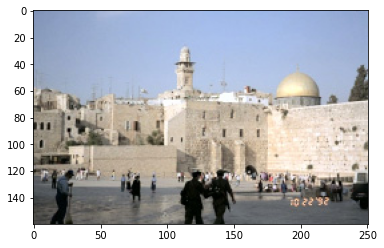

In [5]:
box=[]
for i in range(n):
    box.append(run('./hi1.png'))

In [6]:
print(box)

[(173, 35, 217, 91), (98, 25, 126, 91), (5, 47, 43, 114)]


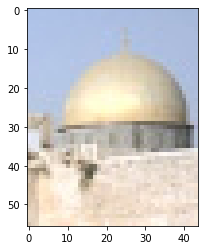

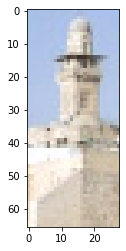

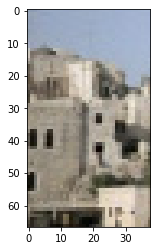

In [7]:
fg=[]
img=cv2.imread('./hi1.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
for i in range(n):
    boxn=box[i]
    fg.append(img[boxn[1]:boxn[3],boxn[0]:boxn[2],:])
    plt.imshow(fg[i])
    plt.show()

In [8]:
box=[[boxx[0]/img.shape[1],boxx[1]/img.shape[0]] for boxx in box]
print(box)

[[0.6892430278884463, 0.21875], [0.3904382470119522, 0.15625], [0.0199203187250996, 0.29375]]


0.9 0.9 0.95 0.95 
(53, 42, 3)
155.76892430278886 (144, 226, 3)
(53, 42, 3)
(63, 27, 3)
88.2390438247012 (144, 226, 3)
(63, 27, 3)
(64, 36, 3)
4.5019920318725095 (144, 226, 3)
(64, 36, 3)


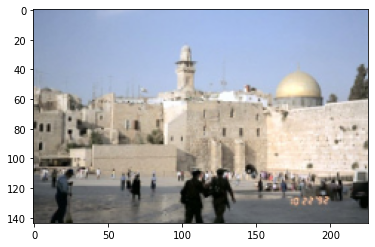

0.8 0.8 0.95 0.95
(50, 40, 3)
124.75298804780877 (115, 181, 3)
(50, 40, 3)
(60, 26, 3)
70.66932270916334 (115, 181, 3)
(60, 26, 3)
(61, 34, 3)
3.605577689243028 (115, 181, 3)
(61, 34, 3)


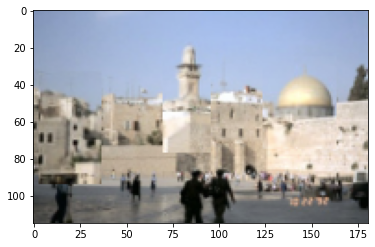

0.8 0.8 0.95 0.95
(48, 38, 3)
99.9402390438247 (92, 145, 3)
(48, 38, 3)
(57, 25, 3)
56.613545816733065 (92, 145, 3)
(57, 25, 3)
(58, 32, 3)
2.8884462151394423 (92, 145, 3)
(58, 32, 3)


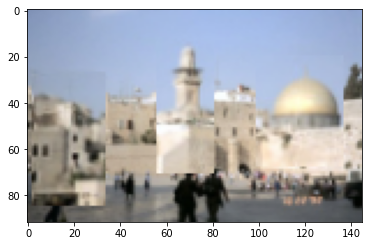

1


In [9]:
while(1):
    arr = list(map(float, input().split()))
    if(len(arr)<4):
        break
    img=cv2.resize(img,None,fx=arr[0],fy=arr[1])
    fg=[cv2.resize(fg[i],None,fx=arr[2],fy=arr[3]) for i in range(n)]
    for i in range(n):
        print(fg[i].shape)
        print(img.shape[1]*box[i][0],img.shape)
        if(img.shape[0]<fg[i].shape[0] or img.shape[1]<fg[i].shape[1]):
            print('error will be raisen')
            sys.exit()
        dx1=int(img.shape[0]*box[i][1])
        dx2=int(img.shape[0]*box[i][1]+fg[i].shape[0])
        dy1=int(img.shape[1]*box[i][0])
        dy2=int(img.shape[1]*box[i][0]+fg[i].shape[1])
        if(dy2>img.shape[1]):
            dy2=img.shape[1]
            dy1=dy2-fg[i].shape[1]
        if(dx2>img.shape[0]):
            dx2=img.shape[0]
            dx1=dx2-fg[i].shape[0]
        img[dx1:dx2,dy1:dy2,:]=fg[i]
        print(fg[i].shape)
    plt.imshow(img)
    plt.show()

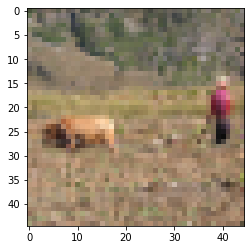

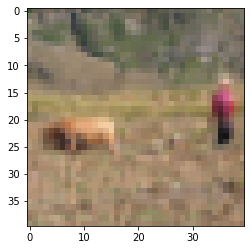

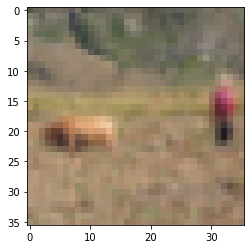

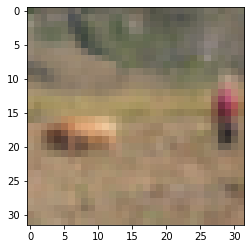

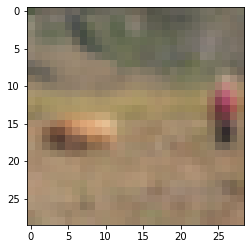

In [10]:
img=cv2.imread('hi.png')
S=cv2.resize(img,(50,50))
S=cv2.cvtColor(S,cv2.COLOR_BGR2RGB)
T=S.copy()
for i in range(5):
    T=cv2.resize(T,None,fx=0.9,fy=0.9)
    plt.imshow(T)
    plt.show()